# Arulandu's Quantitative Estimator

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

/var/folders/fg/n7d57ft153bf46npr6w6jjxr0000gn/T/ipykernel_53606/3854569243.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
np.random.seed(0)

In [3]:
from scipy import stats
from scipy.signal import convolve
from scipy.integrate import quad

In [4]:
import multiprocess as mp

In [26]:
import sklearn
from sklearn.linear_model import LinearRegression

## CDF Estimator

In [190]:
def box_sim(Y, U, r=1, n=100, m=100):
  Ys = Y.rvs(size=n)
  Us = U.rvs(size=r*n)
  Zs = np.concatenate([Ys, Us])

  Z_sample = np.random.choice(Zs, replace=True, size=m)

  est_cdfY = np.vectorize(lambda y : (r+1)*np.mean(Z_sample < y) - r*U.cdf(y))
  return est_cdfY

In [8]:
# Y = stats.gamma(a=2, loc=0, scale=1)
Y = stats.norm(loc=0, scale=1)
U = stats.uniform(loc=-1, scale=2)
Ys_plot = np.linspace(-3, 3, 100)

In [101]:
%%time
n = int(1e2)
B = int(1e4)
m = int(1e1)
r = 2
pool = mp.Pool(processes=mp.cpu_count())
res = np.array(pool.map(lambda _: box_sim(Y, U, r=r, n=n, m=m)(Ys_plot), range(B)))

CPU times: user 59.4 ms, sys: 59.4 ms, total: 119 ms
Wall time: 3.22 s


In [102]:
Yc, Uc = Y.cdf(Ys_plot), U.cdf(Ys_plot)

var_theo_EV = (1/m)*(((r+1)-(1/n))*(Yc+r*Uc) - (1-(1/n))*(Yc**2)-2*r*Yc*Uc-r*(r-(1/n))*(Uc**2))
var_theo_VE = (1/n)*(Yc*(1-Yc)+r*Uc*(1-Uc))
var_theo = var_theo_EV + var_theo_VE

var_sample = np.std(res, axis=0, ddof=1)**2

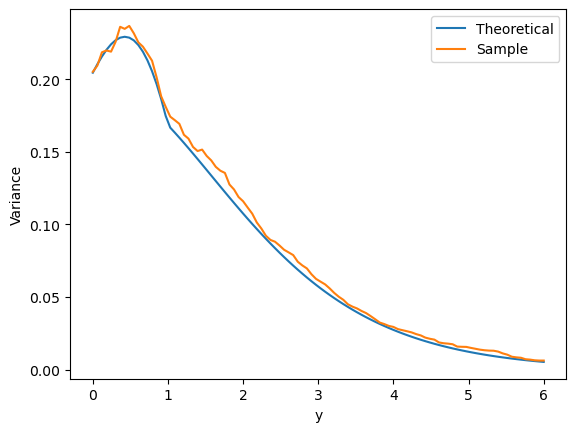

In [103]:
plt.plot(Ys_plot, var_theo, label='Theoretical')
plt.plot(Ys_plot, var_sample, label='Sample')
plt.xlabel("y")
plt.ylabel("Variance")
# plt.plot(Ys_plot, Yc)
plt.legend()

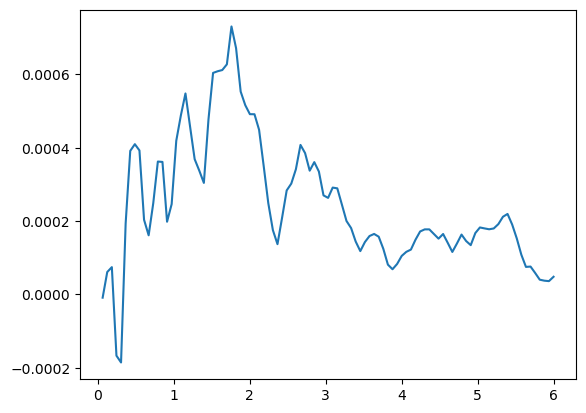

In [104]:
diff = lambda f,g: [(((f[i]+f[i-1])/2)-((g[i]+g[i-1])/2))*(Ys_plot[i]-Ys_plot[i-1]) for i in range(1,len(Ys_plot))]
plt.plot(Ys_plot[1:], diff(var_sample, var_theo))

In [68]:
mipe = sum(np.abs(diff(var_theo, var_sample)))/sum(diff(var_theo,np.zeros_like(var_theo)))
print("MIPE: {:.4f}%".format(mipe*100))

MIPE: 6.9625%


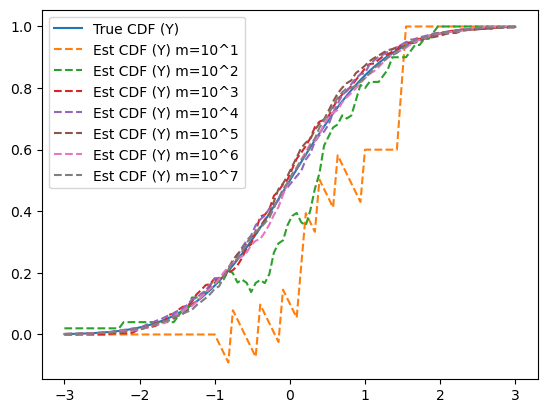

In [44]:
plt.plot(Ys_plot, Y.cdf(Ys_plot), label='True CDF (Y)', linestyle='-')

for k in range(1,8):
  est_cdfY_plot = box_sim(Y, r=1, n=int(1e3), m=int(10**k))(Ys_plot)
  plt.plot(Ys_plot, est_cdfY_plot, label=f'Est CDF (Y) m=10^{k}', linestyle='--')

plt.legend()

1
2
3
4
5
6
7


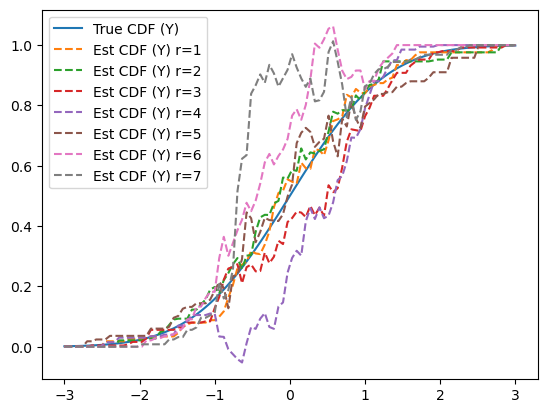

In [54]:
plt.plot(Ys_plot, Y.cdf(Ys_plot), label='True CDF (Y)', linestyle='-')

for k in range(1,8):
  est_cdfY_plot = box_sim(Y, r=k, n=int(1e2), m=int(1e3))(Ys_plot)
  plt.plot(Ys_plot, est_cdfY_plot, label=f'Est CDF (Y) r={k}', linestyle='--')

plt.legend()

In [ ]:
plt.plot(Ys_plot, Y.cdf(Ys_plot), label='True CDF (Y)', linestyle='-')

for k in range(1,7):
  est_cdfY = box_sim(Y, n=int(10**k), m=int(10**4))
  plt.plot(Ys_plot, est_cdfY(Ys_plot), label=f'Est CDF (Y) n=10^{k}', linestyle='--')

plt.legend()

In [6]:
print(mp.cpu_count())

12


## Mean Estimator

In [5]:
def box_sim_mean(Y, U, r=1, n=100, m=100):  
  Ys = Y.rvs(size=n)
  Us = U.rvs(size=r*n)
  Zs = np.concatenate([Ys, Us])

  Z_sample = np.random.choice(Zs, replace=True, size=m)

  EU = quad(lambda y: (y)*U.pdf(y), -np.inf, np.inf)[0]
  est_EY = (r+1)*np.mean(Z_sample) - r*EU
  return est_EY

In [7]:
[box_sim_mean(Y, U, r=10, n=int(1e6), m=int(10**b)) for b in range(1, 7)]

[2.1711305152283686,
 0.21878136514014246,
 -0.2902443964996542,
 -0.0399498167001297,
 0.011165788771792784,
 0.003475603662873668]

In [17]:
%%time
sim = []
bs = range(1,7)
for b in bs:
    B = int(10**b)
    n = int(1e3)
    m = int(1e3)
    r = 1
    pool = mp.Pool(processes=mp.cpu_count())
    res = np.array(pool.map(lambda _: box_sim_mean(Y, U, r=r, n=n, m=m), range(B)))
    print(n, m, B, r, res.shape)
    
    EY = quad(lambda y: (y)*Y.pdf(y), -np.inf, np.inf)[0]
    E_Y2 = quad(lambda y: (y**2)*Y.pdf(y), -np.inf, np.inf)[0]
    EU = quad(lambda y: (y)*U.pdf(y), -np.inf, np.inf)[0]
    E_U2 = quad(lambda y: (y**2)*U.pdf(y), -np.inf, np.inf)[0]
    
    var_theo_EV = (1/m)*((r+1-(1/n))*(E_Y2+r*E_U2)-((1-(1/n))*(EY**2)+2*r*EY*EU+r*(r-(1/n))*(EU**2)))
    var_theo_VE = (1/n)*(E_Y2-(EY**2)+r*(E_U2-(EU**2)))
    var_theo = var_theo_EV + var_theo_VE
    
    var_sample = np.std(res, ddof=1)**2

    sim.append([var_theo, var_theo_EV, var_theo_VE, var_sample])

1000 1000 10 1 (10,)
1000 1000 100 1 (100,)
1000 1000 1000 1 (1000,)
1000 1000 10000 1 (10000,)
1000 1000 100000 1 (100000,)
1000 1000 1000000 1 (1000000,)
CPU times: user 2.01 s, sys: 310 ms, total: 2.32 s
Wall time: 3min 54s


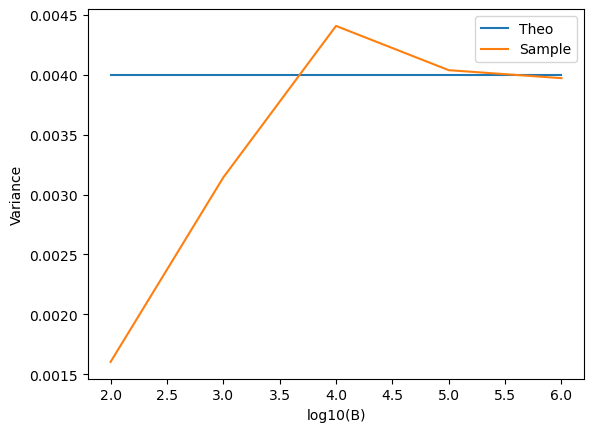

In [19]:
sim = np.array(sim)
plt.plot(bs[1:], sim[:,0][1:], label="Theo")
# plt.plot(bs, sim[:,1], label="EV")
# plt.plot(bs, sim[:,2], label="VE")
plt.plot(bs[1:], sim[:,3][1:], label="Sample")
plt.legend()
plt.xlabel("log10(B)")
plt.ylabel("Variance")
plt.show()

In [138]:
print("Sample Var: {:.8f}".format())
print("Theor  Var: {:.8f}".format(var_theo))

Sample Var: 1.27555468
Theor  Var: 1.62400000


## Privacy Regression

In [294]:
Y = stats.norm(loc=0, scale=1)
U = stats.uniform(loc=-2, scale=4)

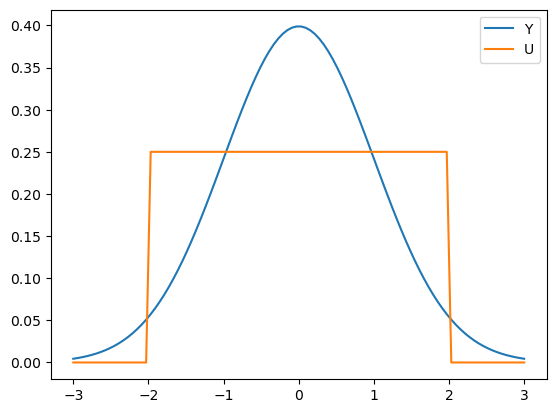

In [295]:
Ys_plot = np.linspace(-3, 3, 100)
plt.plot(Ys_plot, Y.pdf(Ys_plot), label="Y")
plt.plot(Ys_plot, U.pdf(Ys_plot), label="U")
plt.legend()

In [307]:
def privpred(Y, U, r=2, n=int(1e3), model=LinearRegression(), verbose=False):
    Ys = Y.rvs(size=n)
    Us = U.rvs(size=r*n).reshape((n,r))
    Xs = np.column_stack([Ys,Us])

    idx = np.random.rand(*Xs.shape).argsort(axis=1)
    Xs = np.take_along_axis(Xs, idx, axis=1) # shuffled
    
    reg = model.fit(Xs, Ys)
    Y_pred = model.predict(Xs)
    priv = np.mean((Y_pred - Ys)**2)
    
    if verbose:
        plt.plot(Ys, Y_pred, ".", label="Prediction")
        plt.plot([np.min(Ys), np.max(Ys)], [np.min(Ys), np.max(Ys)], "--")
        
    return model.score(Xs, Ys), priv

In [297]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(max_iter=500)
r = 2
n = int(1e3)

Siml: 0.35442729
Theo: 0.33333333
Priv: 0.67894804


/Users/arulandu/lib/miniforge3/envs/stat/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


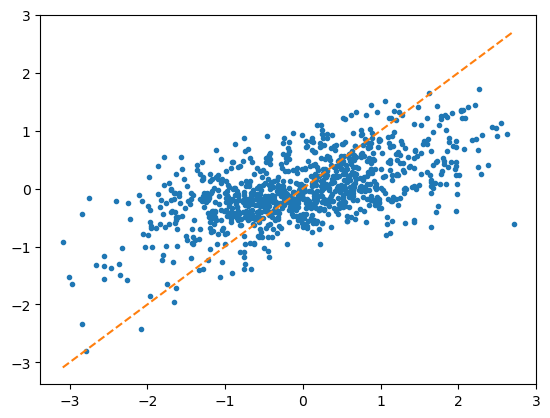

In [298]:
score, priv = privpred(Y, U, r=r, n=n, model=model, verbose=True)
print("Siml: {:.8f}\nTheo: {:.8f}".format(score, 1/(r+1)))
print("Priv: {:.8f}".format(priv))

In [299]:
def KL(Y, U):
    def integrand(y, eps=1e-16): # D_{KL}(U || Y)
        fy, fu = Y.pdf(y), U.pdf(y)
        if np.min(np.abs([fy,fu])) < eps: return 0
        return fu*np.log(fu/fy)
    
    return quad(integrand, -np.inf, np.inf)[0]

In [300]:
Y = stats.norm(loc=0, scale=1)
ss = np.linspace(1, 10, 10)
res = []
for s in ss:
    U = stats.uniform(loc=-s/2, scale=s)
    score, priv = np.mean([privpred(Y, U, r=2, n=int(1e3), model=MLPRegressor(max_iter=500), verbose=False) for _ in range(5)], axis=0)
    res.append([KL(Y, U), score, priv])

/Users/arulandu/lib/miniforge3/envs/stat/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arulandu/lib/miniforge3/envs/stat/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arulandu/lib/miniforge3/envs/stat/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arulandu/lib/miniforge3/envs/stat/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization has

In [306]:
ss[np.argmax(res[:,2])], ss[np.argmin(res[:,1])], ss[np.argmin(res[:,0])]

(5.0, 5.0, 3.0)

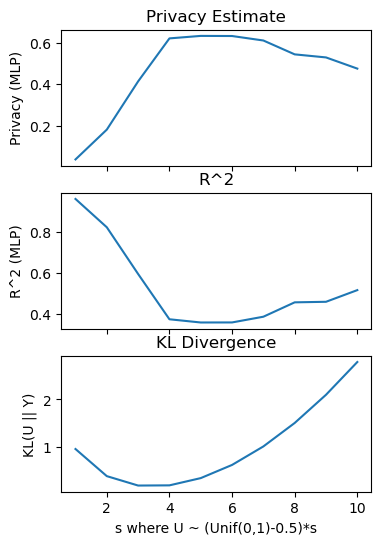

In [304]:
res = np.array(res)
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(4, 6))
axs[0].plot(ss, res[:,2])
axs[0].set_ylabel("Privacy (MLP)")
axs[0].set_title("Privacy Estimate")

axs[1].plot(ss, res[:,1])
axs[1].set_ylabel("R^2 (MLP)")
axs[1].set_title("R^2")

axs[2].plot(ss, res[:,0])
axs[2].set_ylabel("KL(U || Y)")
axs[2].set_xlabel("s where U ~ (Unif(0,1)-0.5)*s")
axs[2].set_title("KL Divergence")
None

## Side Calculations

\begin{align*}
    \text{Var}(\hat{\theta}(y))=&\mathbb{E}[\text{Var}(\hat{\theta}(y)|Z_1,\dots,Z_m)]+\text{Var}(\mathbb{E}[\hat{\theta}(y)|Z_1,\dots,Z_{2n}])\\
    =&\frac{1}{m}\left(\left((r+1)-\frac{1}{n}\right)(\mathbb{P}(Y\leq y)+r\mathbb{P}(U\leq y))\vphantom{\binom{n}{2}}\right.\\
&\left.-\left(1-\frac{1}{n}\right)\mathbb{P}(Y\leq y)^2-2r\mathbb{P}(Y\leq y)\mathbb{P}(U\leq y)-r\left(r-\frac{1}{n}\right)\mathbb{P}(U\leq y)^2\right)\\
    &+\frac{1}{n}(\mathbb{P}(Y\leq y)(1-\mathbb{P}(Y\leq y))+r\mathbb{P}(U\leq y)(1-\mathbb{P}(U\leq y)))
\end{align*}

## Werner's Non-Optional Deconvolution
$$P(Z\leq z)=\int_{y} P(Y\leq y)P(U= z-y)dy=\frac{1}{2}\int_{z-1}^{z+1}P(Y\leq y)dy$$
$$\frac{d}{dz}P(Z\leq z)=\frac{1}{2}\left(P(Y\leq z+1)-P(Y\leq z-1)\right)$$
$$P(z-1\leq Y\leq z+1)=2\cdot \frac{d}{dz}P(Z\leq z)$$
$$P(z-2\leq Y\leq z)=2\cdot \frac{d}{dz}P(Z\leq z-1)$$
$$P(Y\leq y)=\sum_{k=1}^{\infty} 2\cdot \frac{d}{dz}P(Z\leq z)\biggr\rvert_{z=y-2k+1}$$
$$f_{Y}(y)=2\sum_{k=1}^{\infty}\frac{d}{dy}\left(\frac{d}{dz}P(Z\leq z)\biggr\rvert_{z=y-2k+1}\right)=2\sum_{k=1}^{\infty}\frac{d^2}{dz^2}P(Z\leq z)\biggr\rvert_{z=y-2k+1}$$
Let $f_{KDE}(z)$ be the kernel density estimation of $Z$ from the sample. Using the finite element method or a smoothing spline, we estimate $g(z)\approx \frac{d}{dz}f_{KDE}(z)$. Then,
$$F_{Y}(y)=2\sum_{k=1}^{\infty}f_{KDE}(y-2k+1)$$
$$f_{Y}(y)=2\sum_{k=1}^{\infty}g(y-2k+1)$$